In [1]:
"""
"""
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate
!pip install TensorFlow==2.15





  Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
#!pip install accelerate -U

In [3]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

**En este ejercicio debeis entrenar un modelo de clasificación utilizando la librería Transformers.** Dado que el análisis exploratorio ha sido realizado en el ejercicio anterior, en este caso podréis centraros en entrenar el modelo utilizando la librería Transformers, seleccionando un modelo pre-entrenado adecuado, entrenando el modelo y llevando a cabo la evaluación.


**Nota 1**: Este ejercicio requiere el uso de las GPUs de Google Colab. Este Colab debería estar preconfigurado para ejecutarse en GPU, pero si tuviera problemas en la ejecución que me contacte a través del Moodle para buscar soluciones alternativas.

## 0. Imports


In [4]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [5]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
dataset = load_prepare_data(path_data)

In [6]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

Podéis saltarlo en este ejercicio.

## 3. Preprocesado y Normalización

In [7]:
texts = dataset.tweet_text.values
labels = dataset.cyberbullying.values

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels,
                                                                      test_size=.25, random_state=0,stratify = labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels,
                                                                    test_size=.2, random_state=0,stratify = train_labels)


In [9]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnin

## 4. Vectorización

In [10]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Constructor de la clase CustomDataset.
        Parámetros:
        - texts: Lista de textos.
        - labels: Lista de etiquetas correspondientes a los textos.
        - tokenizer: Objeto del tokenizador a utilizar.
        - max_length: Longitud máxima de la secuencia después de la tokenización.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Obtiene un elemento del conjunto de datos.

        Parámetros:
        - idx: Índice del elemento a obtener.

        Devuelve:
        Un diccionario con 'input_ids', 'attention_mask' y 'labels'.
        """
        # Obtener el texto y la etiqueta del índice proporcionado
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Devolver el diccionario con los datos
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [11]:
pd.Series([len(x) for x in texts]).mean()

136.25322905309068

In [12]:
max_length = 280

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)


In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NOT_BULLYING", 1: "BULLYING"}
label2id = {"NOT_BULLYING": 0, "BULLYING": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_path,  num_labels=2, id2label=id2label, label2id=label2id,ignore_mismatched_sizes=True)



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

## 5. Entrenamiento y evaluación de modelos


In [14]:
import accelerate

training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

In [15]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.275600,0.271771,{'accuracy': 0.8989376572546827},{'f1': 0.9403317652884376}
2,0.244300,0.300135,{'accuracy': 0.900754822476936},{'f1': 0.9420218846970438}
3,0.214300,0.431507,{'accuracy': 0.8983785294939893},{'f1': 0.9409183258837871}
4,0.168200,0.534620,{'accuracy': 0.8932065977075762},{'f1': 0.9371710526315791}


Trainer is attempting to log a value of "{'accuracy': 0.8989376572546827}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9403317652884376}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.900754822476936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9420218846970438}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8983785294939893}" of type <class

TrainOutput(global_step=14308, training_loss=0.22353774127528292, metrics={'train_runtime': 6737.886, 'train_samples_per_second': 16.988, 'train_steps_per_second': 2.124, 'total_flos': 1.6469518732464e+16, 'train_loss': 0.22353774127528292, 'epoch': 4.0})

In [17]:
model_dir = '/content/drive/My Drive/'
trainer.save_model(model_dir + 'ModeloLenguaje')

In [18]:
# Make predictions on the test data
trainer.evaluate(test_dataset)



Trainer is attempting to log a value of "{'accuracy': 0.8931476977270821}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9370428938525399}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2895892858505249,
 'eval_accuracy': {'accuracy': 0.8931476977270821},
 'eval_f1_score': {'f1': 0.9370428938525399},
 'eval_runtime': 211.8918,
 'eval_samples_per_second': 56.269,
 'eval_steps_per_second': 7.037,
 'epoch': 4.0}

In [19]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)

[[1168  818]
 [ 456 9481]]
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1986
           1       0.92      0.95      0.94      9937

    accuracy                           0.89     11923
   macro avg       0.82      0.77      0.79     11923
weighted avg       0.89      0.89      0.89     11923



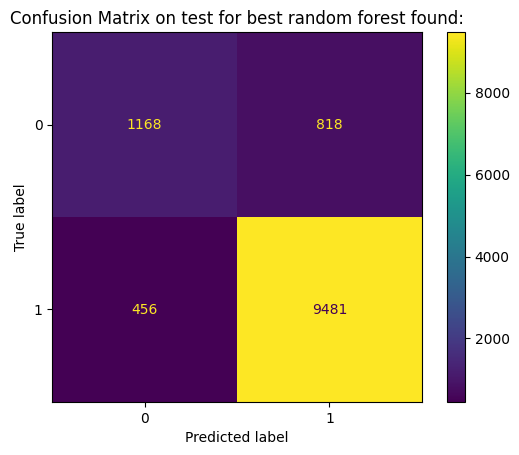

In [21]:
import matplotlib.pyplot as plt
y_true = [x["labels"].item() for x in test_dataset]
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

classes = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.title('Confusion Matrix on test for best random forest found:')
plt.show()

### Esta técnica que utiliza el modelo encoder-based de lenguaje contextual preentrenado "cardiffnlp/twitter-roberta-base-sentiment-latest"(Entrenado con 124 millones de tweets) da un accuracy mucho mejor que el conseguido con el análisis de texto tradicional. Los TP y TN rates que se consiguieron con el embedding vectorial, random forest, y la técnica de remuestreo BorderlineSMOTE fueron de 64% y 83% respectivamente. Mientras que este modelo consigue TP rate de 58% y TN Rate de ¡95%!. El fallo del TP Rate de este modelo sería sencillamente solucionable con un remuestreo como el que se hizo en la técnica anterior, pero por problemas que tengo con google colab se me hace imposible revisar los resultados que esto me daría.

### Es obvio el poder que sostienen estos modelos de lenguaje preentrenados, vale la pena profundizar mi conocimiento acerca de ellos y sin duda lo haré.